In [69]:
import os
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [70]:
# Load the data into a pandas DataFrame
# data = pd.read_csv('../data/uk/processed/full_preprocessed.csv')
BRAZIL_DATA_PATH = '../data/brazil/'
brazil_csv_file = BRAZIL_DATA_PATH + 'processed/uebb_df_2.csv'

# Load data for UK Turbine 2
print(f"Reading following file into pd df: {brazil_csv_file}")
df = pd.read_csv(brazil_csv_file)
df


Reading following file into pd df: ../data/brazil/processed/uebb_df_2.csv


,timestamp,wind_speed,wind_direction,wind_speed_std,wind_direction_std,wind_speed_max,wind_speed_min,wind_speed_cube,air_temperature,relative_humidity,air_pressure,logger_temperature,battery_V,ws_u,ws_v,ws_w,sonic_temperature,sonic_wind_speed,sonic_wind_direction,tilt_X,tilt_Y,tilt_X_std,tilt_Y_std,wind_speed_nacelle,wind_speed_nacelle_max,wind_speed_nacelle_min,rotor_rpm,rotor_rpm_max,rotor_rpm_min,active_power_total,active_power_total_max,active_power_total_min,act_position,air_density,UST,UST_flag,HS,HS_flag,TKE,LMO,ws_w_corrected
0,2013-08-01 00:00:00,13.06000,117.833333,1.09425,3.7845,15.6200,9.65750,2288.0500,298.635,79.170,1009.2,26.74,12.50,-11.4120,3.7029,-0.3583,300.880,14.23,107.5,-5.6425,3.9383,1.4354,2.7211,12.4,16.2,8.8,30.93,32.20,28.39,793.0,825.0,582.0,132.0,1.1665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-08-01 00:10:00,12.19750,113.466667,1.57650,4.2090,15.6200,7.36325,1926.6000,298.615,78.620,1009.1,26.69,12.50,-11.2280,4.0687,-0.0021,300.816,13.66,109.7,-5.6139,4.0239,1.5061,2.6654,11.9,15.9,9.3,30.79,32.68,28.17,783.0,835.0,544.0,134.0,1.1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-08-01 00:20:00,12.20500,112.900000,1.32150,4.3325,15.1600,7.82075,1903.7250,298.545,79.875,1009.0,26.65,12.50,-11.0000,3.4044,-0.2243,300.798,13.52,106.7,-5.6269,3.9073,1.0126,2.0478,12.5,16.3,10.5,30.97,32.04,29.06,798.0,826.0,679.0,135.0,1.1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-08-01 00:30:00,11.75750,114.566667,1.45950,4.8590,15.3900,7.59150,1717.4750,298.515,79.960,1009.1,26.61,12.49,-10.8120,3.9910,0.1447,300.791,13.01,110.2,-5.6639,3.9574,1.0164,2.0993,11.6,14.9,10.3,31.02,32.59,29.73,798.0,832.0,745.0,135.0,1.1668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-08-01 00:40:00,12.45500,117.933333,1.40875,3.4690,14.9300,6.67500,2015.8500,298.470,78.430,1009.0,26.57,12.49,-10.5880,4.7564,-0.1570,300.690,13.78,113.1,-5.6087,4.0260,1.4690,2.8011,11.0,16.2,8.7,30.53,32.19,28.29,770.0,826.0,562.0,136.0,1.1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2014-07-31 23:10:00,8.53175,100.800000,0.71175,3.1935,10.4175,6.33875,659.9675,298.660,82.700,1009.4,27.15,12.27,-9.6582,1.1271,-0.4139,301.596,9.74,96.7,-5.7454,3.8520,0.1303,0.3459,8.9,10.1,7.0,27.43,28.72,24.39,433.0,583.0,266.0,-234.0,1.1658,0.32686,1.0,6.2750,1.0,0.37743,0.37743,0.13953
52556,2014-07-31 23:20:00,8.68325,104.500000,0.75800,3.5735,10.5450,6.34900,709.8025,298.625,82.750,1009.3,27.18,12.27,-10.0680,1.9938,-0.3261,301.608,10.28,101.2,-5.7472,3.8729,0.1402,0.3820,9.3,10.4,7.3,27.61,28.70,25.04,449.0,580.0,285.0,-232.0,1.1659,0.33975,1.0,6.7703,1.0,0.40388,0.40388,0.13273
52557,2014-07-31 23:30:00,8.84850,105.700000,1.11675,3.4290,10.9125,5.63875,773.0975,298.550,82.600,1009.3,27.18,12.27,-10.4690,2.2256,-0.2052,301.621,10.71,102.0,-5.7606,3.8721,0.1589,0.4695,9.4,10.4,8.0,28.01,29.31,26.00,508.0,684.0,324.0,-227.0,1.1662,0.35264,1.0,7.2656,1.0,0.43034,0.43034,0.12594
52558,2014-07-31 23:40:00,8.78175,107.450000,0.97425,4.0485,10.9800,6.10850,748.8150,298.535,82.700,1009.3,27.18,12.26,-10.3060,2.4874,-0.0469,301.586,10.62,103.6,-5.7454,3.8585,0.1783,0.4884,9.8,10.4,8.6,28.41,29.12,27.16,560.0,651.0,422.0,-226.0,1.1662,0.36553,1.0,7.7608,1.0,0.45679,0.45679,0.11915


In [71]:
df.columns

Index(['timestamp', 'wind_speed', 'wind_direction', 'wind_speed_std',
       'wind_direction_std', 'wind_speed_max', 'wind_speed_min',
       'wind_speed_cube', 'air_temperature', 'relative_humidity',
       'air_pressure', 'logger_temperature', 'battery_V', 'ws_u', 'ws_v',
       'ws_w', 'sonic_temperature', 'sonic_wind_speed', 'sonic_wind_direction',
       'tilt_X', 'tilt_Y', 'tilt_X_std', 'tilt_Y_std', 'wind_speed_nacelle',
       'wind_speed_nacelle_max', 'wind_speed_nacelle_min', 'rotor_rpm',
       'rotor_rpm_max', 'rotor_rpm_min', 'active_power_total',
       'active_power_total_max', 'active_power_total_min', 'act_position',
       'air_density', 'UST', 'UST_flag', 'HS', 'HS_flag', 'TKE', 'LMO',
       'ws_w_corrected'],
      dtype='object')

In [72]:
# drop all columns in df where either 'max' or 'min' or 'stddev' or 'standard_deviation' is in the column name
# data = df.loc[:, ~df.columns.str.contains('max|min|stddev|standard_deviation|lost_production|time_based|data_availability')]
# data

In [73]:
# Preprocess the data
# Assuming the 'timestamp' column contains the timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df

,wind_speed,wind_direction,wind_speed_std,wind_direction_std,wind_speed_max,wind_speed_min,wind_speed_cube,air_temperature,relative_humidity,air_pressure,logger_temperature,battery_V,ws_u,ws_v,ws_w,sonic_temperature,sonic_wind_speed,sonic_wind_direction,tilt_X,tilt_Y,tilt_X_std,tilt_Y_std,wind_speed_nacelle,wind_speed_nacelle_max,wind_speed_nacelle_min,rotor_rpm,rotor_rpm_max,rotor_rpm_min,active_power_total,active_power_total_max,active_power_total_min,act_position,air_density,UST,UST_flag,HS,HS_flag,TKE,LMO,ws_w_corrected
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-08-01 00:00:00,13.06000,117.833333,1.09425,3.7845,15.6200,9.65750,2288.0500,298.635,79.170,1009.2,26.74,12.50,-11.4120,3.7029,-0.3583,300.880,14.23,107.5,-5.6425,3.9383,1.4354,2.7211,12.4,16.2,8.8,30.93,32.20,28.39,793.0,825.0,582.0,132.0,1.1665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:10:00,12.19750,113.466667,1.57650,4.2090,15.6200,7.36325,1926.6000,298.615,78.620,1009.1,26.69,12.50,-11.2280,4.0687,-0.0021,300.816,13.66,109.7,-5.6139,4.0239,1.5061,2.6654,11.9,15.9,9.3,30.79,32.68,28.17,783.0,835.0,544.0,134.0,1.1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:20:00,12.20500,112.900000,1.32150,4.3325,15.1600,7.82075,1903.7250,298.545,79.875,1009.0,26.65,12.50,-11.0000,3.4044,-0.2243,300.798,13.52,106.7,-5.6269,3.9073,1.0126,2.0478,12.5,16.3,10.5,30.97,32.04,29.06,798.0,826.0,679.0,135.0,1.1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:30:00,11.75750,114.566667,1.45950,4.8590,15.3900,7.59150,1717.4750,298.515,79.960,1009.1,26.61,12.49,-10.8120,3.9910,0.1447,300.791,13.01,110.2,-5.6639,3.9574,1.0164,2.0993,11.6,14.9,10.3,31.02,32.59,29.73,798.0,832.0,745.0,135.0,1.1668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:40:00,12.45500,117.933333,1.40875,3.4690,14.9300,6.67500,2015.8500,298.470,78.430,1009.0,26.57,12.49,-10.5880,4.7564,-0.1570,300.690,13.78,113.1,-5.6087,4.0260,1.4690,2.8011,11.0,16.2,8.7,30.53,32.19,28.29,770.0,826.0,562.0,136.0,1.1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-07-31 23:10:00,8.53175,100.800000,0.71175,3.1935,10.4175,6.33875,659.9675,298.660,82.700,1009.4,27.15,12.27,-9.6582,1.1271,-0.4139,301.596,9.74,96.7,-5.7454,3.8520,0.1303,0.3459,8.9,10.1,7.0,27.43,28.72,24.39,433.0,583.0,266.0,-234.0,1.1658,0.32686,1.0,6.2750,1.0,0.37743,0.37743,0.13953
2014-07-31 23:20:00,8.68325,104.500000,0.75800,3.5735,10.5450,6.34900,709.8025,298.625,82.750,1009.3,27.18,12.27,-10.0680,1.9938,-0.3261,301.608,10.28,101.2,-5.7472,3.8729,0.1402,0.3820,9.3,10.4,7.3,27.61,28.70,25.04,449.0,580.0,285.0,-232.0,1.1659,0.33975,1.0,6.7703,1.0,0.40388,0.40388,0.13273
2014-07-31 23:30:00,8.84850,105.700000,1.11675,3.4290,10.9125,5.63875,773.0975,298.550,82.600,1009.3,27.18,12.27,-10.4690,2.2256,-0.2052,301.621,10.71,102.0,-5.7606,3.8721,0.1589,0.4695,9.4,10.4,8.0,28.01,29.31,26.00,508.0,684.0,324.0,-227.0,1.1662,0.35264,1.0,7.2656,1.0,0.43034,0.43034,0.12594


In [74]:
data = df.sort_index()
data

,wind_speed,wind_direction,wind_speed_std,wind_direction_std,wind_speed_max,wind_speed_min,wind_speed_cube,air_temperature,relative_humidity,air_pressure,logger_temperature,battery_V,ws_u,ws_v,ws_w,sonic_temperature,sonic_wind_speed,sonic_wind_direction,tilt_X,tilt_Y,tilt_X_std,tilt_Y_std,wind_speed_nacelle,wind_speed_nacelle_max,wind_speed_nacelle_min,rotor_rpm,rotor_rpm_max,rotor_rpm_min,active_power_total,active_power_total_max,active_power_total_min,act_position,air_density,UST,UST_flag,HS,HS_flag,TKE,LMO,ws_w_corrected
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-08-01 00:00:00,13.06000,117.833333,1.09425,3.7845,15.6200,9.65750,2288.0500,298.635,79.170,1009.2,26.74,12.50,-11.4120,3.7029,-0.3583,300.880,14.23,107.5,-5.6425,3.9383,1.4354,2.7211,12.4,16.2,8.8,30.93,32.20,28.39,793.0,825.0,582.0,132.0,1.1665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:10:00,12.19750,113.466667,1.57650,4.2090,15.6200,7.36325,1926.6000,298.615,78.620,1009.1,26.69,12.50,-11.2280,4.0687,-0.0021,300.816,13.66,109.7,-5.6139,4.0239,1.5061,2.6654,11.9,15.9,9.3,30.79,32.68,28.17,783.0,835.0,544.0,134.0,1.1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:20:00,12.20500,112.900000,1.32150,4.3325,15.1600,7.82075,1903.7250,298.545,79.875,1009.0,26.65,12.50,-11.0000,3.4044,-0.2243,300.798,13.52,106.7,-5.6269,3.9073,1.0126,2.0478,12.5,16.3,10.5,30.97,32.04,29.06,798.0,826.0,679.0,135.0,1.1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:30:00,11.75750,114.566667,1.45950,4.8590,15.3900,7.59150,1717.4750,298.515,79.960,1009.1,26.61,12.49,-10.8120,3.9910,0.1447,300.791,13.01,110.2,-5.6639,3.9574,1.0164,2.0993,11.6,14.9,10.3,31.02,32.59,29.73,798.0,832.0,745.0,135.0,1.1668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 00:40:00,12.45500,117.933333,1.40875,3.4690,14.9300,6.67500,2015.8500,298.470,78.430,1009.0,26.57,12.49,-10.5880,4.7564,-0.1570,300.690,13.78,113.1,-5.6087,4.0260,1.4690,2.8011,11.0,16.2,8.7,30.53,32.19,28.29,770.0,826.0,562.0,136.0,1.1672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-07-31 23:10:00,8.53175,100.800000,0.71175,3.1935,10.4175,6.33875,659.9675,298.660,82.700,1009.4,27.15,12.27,-9.6582,1.1271,-0.4139,301.596,9.74,96.7,-5.7454,3.8520,0.1303,0.3459,8.9,10.1,7.0,27.43,28.72,24.39,433.0,583.0,266.0,-234.0,1.1658,0.32686,1.0,6.2750,1.0,0.37743,0.37743,0.13953
2014-07-31 23:20:00,8.68325,104.500000,0.75800,3.5735,10.5450,6.34900,709.8025,298.625,82.750,1009.3,27.18,12.27,-10.0680,1.9938,-0.3261,301.608,10.28,101.2,-5.7472,3.8729,0.1402,0.3820,9.3,10.4,7.3,27.61,28.70,25.04,449.0,580.0,285.0,-232.0,1.1659,0.33975,1.0,6.7703,1.0,0.40388,0.40388,0.13273
2014-07-31 23:30:00,8.84850,105.700000,1.11675,3.4290,10.9125,5.63875,773.0975,298.550,82.600,1009.3,27.18,12.27,-10.4690,2.2256,-0.2052,301.621,10.71,102.0,-5.7606,3.8721,0.1589,0.4695,9.4,10.4,8.0,28.01,29.31,26.00,508.0,684.0,324.0,-227.0,1.1662,0.35264,1.0,7.2656,1.0,0.43034,0.43034,0.12594


In [75]:
# get columns where at least one is not nan
# data = data.loc[:, data.notna().any(axis=0)]
# len(data.columns)

In [76]:
# drop all columns where percentage of NaN values is < 0.25

nan_data = data.loc[:, data.isnull().mean() >= 0.25]
nan_data.columns


Index([], dtype='object')

In [77]:
data.isnull().mean().to_dict()

{'wind_speed': 0.0007420091324200913,
 'wind_direction': 0.0007420091324200913,
 'wind_speed_std': 0.0007420091324200913,
 'wind_direction_std': 0.0007420091324200913,
 'wind_speed_max': 0.0007420091324200913,
 'wind_speed_min': 0.0007420091324200913,
 'wind_speed_cube': 0.0007420091324200913,
 'air_temperature': 0.0007420091324200913,
 'relative_humidity': 0.0007420091324200913,
 'air_pressure': 0.0007420091324200913,
 'logger_temperature': 0.0007420091324200913,
 'battery_V': 0.0007420091324200913,
 'ws_u': 0.0007420091324200913,
 'ws_v': 0.0007420091324200913,
 'ws_w': 0.0007420091324200913,
 'sonic_temperature': 0.0,
 'sonic_wind_speed': 0.0,
 'sonic_wind_direction': 0.0,
 'tilt_X': 0.0007420091324200913,
 'tilt_Y': 0.0007420091324200913,
 'tilt_X_std': 0.0007420091324200913,
 'tilt_Y_std': 0.0007420091324200913,
 'wind_speed_nacelle': 0.002454337899543379,
 'wind_speed_nacelle_max': 0.002454337899543379,
 'wind_speed_nacelle_min': 0.002454337899543379,
 'rotor_rpm': 0.002454337899

In [78]:
data["season"] = data.index.month % 12 // 3
data["month"] = data.index.month
data['hour'] = data.index.hour
# data['dayofweek'] = data.index.dayofweek
data['quarter'] = data.index.quarter
# data['year'] = data.index.year
# data['dayofyear'] = data.index.dayofyear
data['day'] = data.index.day

In [79]:
# encode all cyclic features
# data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24.0)
# data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24.0)
# data['dayofweek_sin'] = np.sin(data.dayofweek*(2.*np.pi/7))
# data['dayofweek_cos'] = np.cos(data.dayofweek*(2.*np.pi/7))
# data['dayofyear_sin'] = np.sin((data.dayofyear-1)*(2.*np.pi/365))
# data['dayofyear_cos'] = np.cos((data.dayofyear-1)*(2.*np.pi/365))
# data['dayofmonth_sin'] = np.sin((data.dayofmonth-1)*(2.*np.pi/31))
# data['dayofmonth_cos'] = np.cos((data.dayofmonth-1)*(2.*np.pi/31))
# data['month_sin'] = np.sin((data.month-1)*(2.*np.pi/12))
# data['month_cos'] = np.cos((data.month-1)*(2.*np.pi/12))
# data['quarter_sin'] = np.sin((data.quarter-1)*(2.*np.pi/4))
# data['quarter_cos'] = np.cos((data.quarter-1)*(2.*np.pi/4))
# data['season_sin'] = np.sin((data.season-1)*(2.*np.pi/4))
# data['season_cos'] = np.cos((data.season-1)*(2.*np.pi/4))

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data = encode(data, 'hour', 24)
data = encode(data, 'month', 12)
data = encode(data, 'quarter', 4)
data = encode(data, 'season', 4)
data = encode(data, 'day', 31)

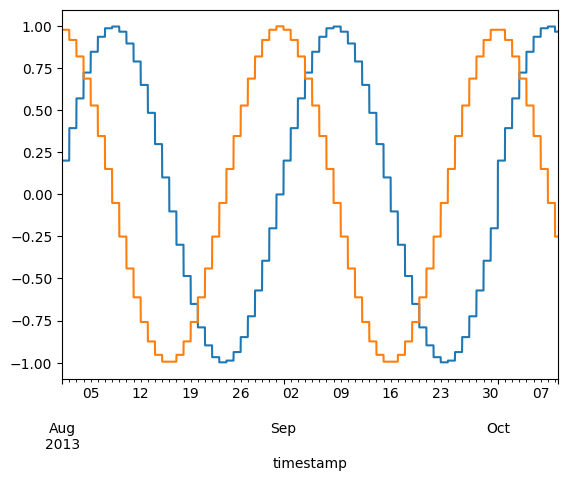

In [80]:
# plot the cyclic features

sample = data[0:10000]
ax = sample['day_sin'].plot()
ax = sample['day_cos'].plot()

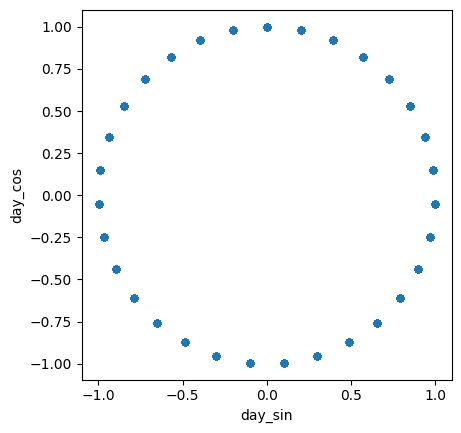

In [81]:
ax = sample.plot.scatter('day_sin', 'day_cos').set_aspect('equal')

In [82]:
# Season
# data["season"] = data.index.month % 12 // 3
# one hot encode season column using values 0 and 1
# data = pd.get_dummies(data, columns=['season'])

# print(data.head())
target_variable = 'active_power_total'

# Shift the target variable for different horizons
data['power_next_step'] = data[target_variable].shift(-1)
data['power_next_hour'] = data[target_variable].shift(-6)  # Assuming 10-minute intervals
data['power_next_day'] = data[target_variable].shift(-144)  # Assuming 10-minute intervals

# Drop rows with NaN values in the shifted columns
data.dropna(subset=['power_next_step', 'power_next_hour', 'power_next_day'], inplace=True)

data['power_1h_mean'] = data[target_variable].rolling(window = 6).mean()
data['power_12h_mean'] = data[target_variable].rolling(window = 6*12).mean()
data['power_24h_mean'] = data[target_variable].rolling(window = 6*24).mean()
data['power_1h_std'] = data[target_variable].rolling(window = 6).std()
data['power_12h_std'] = data[target_variable].rolling(window = 6*12).std()
data['power_24h_std'] = data[target_variable].rolling(window = 6*24).std()
data['power_1h_max'] = data[target_variable].rolling(window = 6).max()
data['power_12h_max'] = data[target_variable].rolling(window = 6*12).max()
data['power_24h_max'] = data[target_variable].rolling(window = 6*24).max()
data['power_1h_min'] = data[target_variable].rolling(window = 6).min()
data['power_12h_min'] = data[target_variable].rolling(window = 6*12).min()
data['power_24h_min'] = data[target_variable].rolling(window = 6*24).min()

# Split the data into training and test sets
train_size = int(len(data) * 0.80)
val_size = int(len(data) * 0.10)
train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]



In [83]:
train_data.tail(1)

,wind_speed,wind_direction,wind_speed_std,wind_direction_std,wind_speed_max,wind_speed_min,wind_speed_cube,air_temperature,relative_humidity,air_pressure,logger_temperature,battery_V,ws_u,ws_v,ws_w,sonic_temperature,sonic_wind_speed,sonic_wind_direction,tilt_X,tilt_Y,tilt_X_std,tilt_Y_std,wind_speed_nacelle,wind_speed_nacelle_max,wind_speed_nacelle_min,rotor_rpm,rotor_rpm_max,rotor_rpm_min,active_power_total,active_power_total_max,active_power_total_min,act_position,air_density,UST,UST_flag,HS,HS_flag,TKE,LMO,ws_w_corrected,season,month,hour,quarter,day,hour_sin,hour_cos,month_sin,month_cos,quarter_sin,quarter_cos,season_sin,season_cos,day_sin,day_cos,power_next_step,power_next_hour,power_next_day,power_1h_mean,power_12h_mean,power_24h_mean,power_1h_std,power_12h_std,power_24h_std,power_1h_max,power_12h_max,power_24h_max,power_1h_min,power_12h_min,power_24h_min
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-05-17 17:10:00,4.4075,65.12,0.324,3.047,5.12325,3.335,88.565,299.88,84.65,1003.6,31.19,12.69,-3.9866,-2.3048,-0.6107,303.135,4.609,59.97,-5.6473,3.9311,0.0318,0.0762,4.9,5.9,3.9,14.3,15.98,13.31,44.0,64.0,18.0,92.0,1.1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,17,2,17,-0.965926,-0.258819,0.5,-0.866025,1.224647e-16,-1.0,1.0,6.123234e-17,-0.299363,-0.954139,33.0,23.0,34.0,35.166667,40.194444,66.701389,7.026142,24.164716,40.399591,44.0,89.0,161.0,27.0,0.0,0.0


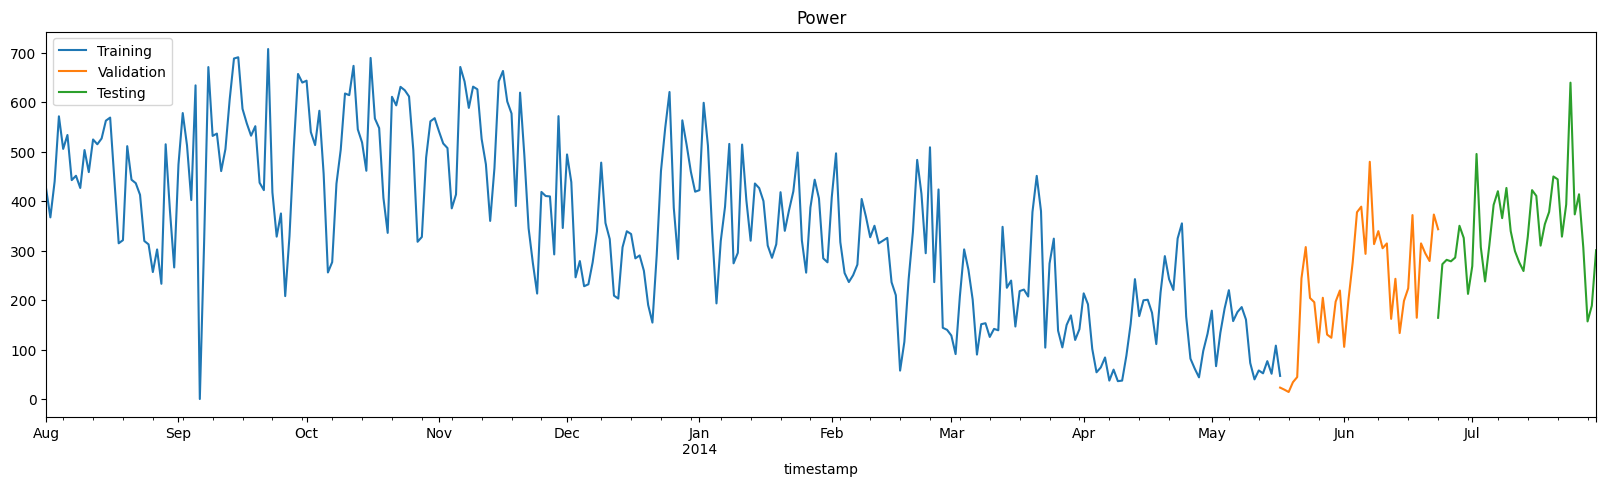

In [84]:
# period = slice('02-2020', '11-2020')
figure, ax = plt.subplots(figsize=(20, 5))
train_data.resample('D').mean().plot(ax=ax, label="Training", y="power_next_step")
val_data.resample('D').mean().plot(ax=ax, label="Validation", y="power_next_step")
test_data.resample('D').mean().plot(ax=ax, label="Testing",  y="power_next_step", title="Power")
plt.show()

In [85]:
# get columns with correlation above 0.75 to 'power_(kw)'
# corr = data.corr()
# corr_cols = corr['power_(kw)'][corr['power_(kw)'] > 0.75].index
# features = list(corr_cols)
# Define the input features and target variables for different horizons
# features = ['wind_speed', 'ambient_temperature', 'wind_direction', 'season', 'long_term_wind']
# features list is all columns of df except for the target columns
features = list(data.columns)
features.remove(target_variable) if target_variable in features else None
features.remove('active_power_total_min') if 'active_power_total_min' in features else None
features.remove('active_power_total_max') if 'active_power_total_max' in features else None
features.remove('power_next_step') if 'power_next_step' in features else None
features.remove('power_next_hour') if 'power_next_hour' in features else None
features.remove('power_next_day') if 'power_next_day' in features else None
target_next_step = 'power_next_step'
target_next_hour = 'power_next_hour'
target_next_day = 'power_next_day'

In [86]:
features

['wind_speed',
 'wind_direction',
 'wind_speed_std',
 'wind_direction_std',
 'wind_speed_max',
 'wind_speed_min',
 'wind_speed_cube',
 'air_temperature',
 'relative_humidity',
 'air_pressure',
 'logger_temperature',
 'battery_V',
 'ws_u',
 'ws_v',
 'ws_w',
 'sonic_temperature',
 'sonic_wind_speed',
 'sonic_wind_direction',
 'tilt_X',
 'tilt_Y',
 'tilt_X_std',
 'tilt_Y_std',
 'wind_speed_nacelle',
 'wind_speed_nacelle_max',
 'wind_speed_nacelle_min',
 'rotor_rpm',
 'rotor_rpm_max',
 'rotor_rpm_min',
 'act_position',
 'air_density',
 'UST',
 'UST_flag',
 'HS',
 'HS_flag',
 'TKE',
 'LMO',
 'ws_w_corrected',
 'season',
 'month',
 'hour',
 'quarter',
 'day',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos',
 'quarter_sin',
 'quarter_cos',
 'season_sin',
 'season_cos',
 'day_sin',
 'day_cos',
 'power_1h_mean',
 'power_12h_mean',
 'power_24h_mean',
 'power_1h_std',
 'power_12h_std',
 'power_24h_std',
 'power_1h_max',
 'power_12h_max',
 'power_24h_max',
 'power_1h_min',
 'power_12h_min',
 

In [87]:
features.extend(["season", "month", "hour", "quarter", "power_1h_mean", "power_12h_mean", "power_24h_mean", "power_1h_std", "power_12h_std", "power_24h_std", "power_1h_max", "power_12h_max", "power_24h_max", "power_1h_min", "power_12h_min", "power_24h_min"])
features = list(set(features))
features

['wind_speed_cube',
 'battery_V',
 'day_cos',
 'wind_speed',
 'power_24h_mean',
 'power_12h_std',
 'power_1h_mean',
 'power_1h_min',
 'rotor_rpm_max',
 'wind_speed_std',
 'air_temperature',
 'rotor_rpm_min',
 'quarter_sin',
 'sonic_wind_direction',
 'wind_speed_max',
 'month_cos',
 'air_density',
 'UST_flag',
 'hour_cos',
 'power_12h_mean',
 'hour_sin',
 'HS_flag',
 'power_24h_max',
 'relative_humidity',
 'act_position',
 'sonic_temperature',
 'ws_u',
 'wind_direction',
 'quarter',
 'power_1h_std',
 'power_12h_min',
 'LMO',
 'power_24h_std',
 'power_12h_max',
 'hour',
 'ws_w',
 'quarter_cos',
 'ws_w_corrected',
 'tilt_Y_std',
 'season_sin',
 'ws_v',
 'tilt_X_std',
 'wind_direction_std',
 'wind_speed_min',
 'TKE',
 'wind_speed_nacelle_max',
 'wind_speed_nacelle',
 'air_pressure',
 'wind_speed_nacelle_min',
 'UST',
 'month',
 'month_sin',
 'day_sin',
 'power_1h_max',
 'season',
 'season_cos',
 'sonic_wind_speed',
 'power_24h_min',
 'tilt_X',
 'tilt_Y',
 'rotor_rpm',
 'HS',
 'logger_tempe

In [88]:
# Prepare the training and test data for different horizons
X_train, y_train_next_step = train_data[features], train_data[target_next_step]
X_val, y_val_next_step = val_data[features], val_data[target_next_step]
X_test, y_test_next_step = test_data[features], test_data[target_next_step]

X_train, y_train_next_hour = train_data[features], train_data[target_next_hour]
X_val, y_val_next_hour = val_data[features], val_data[target_next_hour]
X_test, y_test_next_hour = test_data[features], test_data[target_next_hour]

X_train, y_train_next_day = train_data[features], train_data[target_next_day]
X_val, y_val_next_day = val_data[features], val_data[target_next_day]
X_test, y_test_next_day = test_data[features], test_data[target_next_day]


[0]	validation_0-rmse:268.91901
[1]	validation_0-rmse:242.93531
[2]	validation_0-rmse:219.74006
[3]	validation_0-rmse:198.77083


/Users/lena/Code/uni/ss23/mlses/mlses-wind-power-forecast/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:180.58792
[5]	validation_0-rmse:163.92347
[6]	validation_0-rmse:149.02840
[7]	validation_0-rmse:135.84776
[8]	validation_0-rmse:124.08349
[9]	validation_0-rmse:113.73327
[10]	validation_0-rmse:104.64265
[11]	validation_0-rmse:96.55824
[12]	validation_0-rmse:89.49228
[13]	validation_0-rmse:83.28588
[14]	validation_0-rmse:77.85891
[15]	validation_0-rmse:73.18538
[16]	validation_0-rmse:69.22759
[17]	validation_0-rmse:65.65989
[18]	validation_0-rmse:62.64686
[19]	validation_0-rmse:60.35494
[20]	validation_0-rmse:58.13044
[21]	validation_0-rmse:56.28004
[22]	validation_0-rmse:54.72156
[23]	validation_0-rmse:53.49076
[24]	validation_0-rmse:52.36385
[25]	validation_0-rmse:51.57430
[26]	validation_0-rmse:51.08411
[27]	validation_0-rmse:50.67115
[28]	validation_0-rmse:50.20915
[29]	validation_0-rmse:49.78957
[30]	validation_0-rmse:49.39999
[31]	validation_0-rmse:49.03500
[32]	validation_0-rmse:48.77504
[33]	validation_0-rmse:48.59388
[34]	validation_0-rmse:48.50768
[35]	va

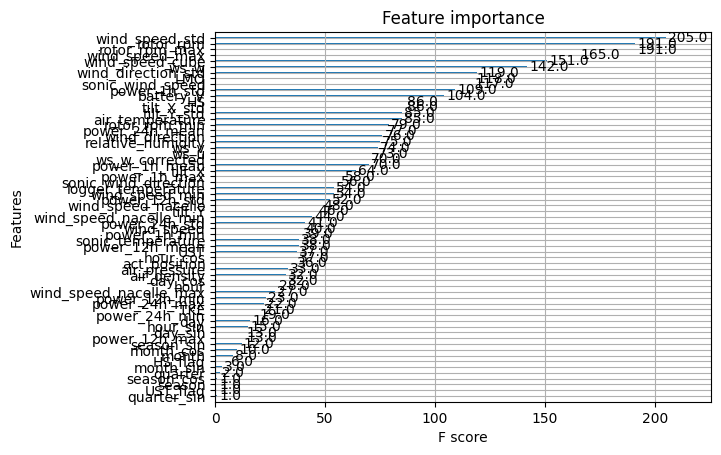

In [89]:
# Train the XGBoost model for the next step prediction
model_next_step = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8,)
model_next_step.fit(X_train, y_train_next_step, eval_set=[(X_val, y_val_next_step)], early_stopping_rounds=50, verbose=True)

# Perform hyper parameter tuning
# model_next_step = xgb.XGBRegressor()
# param_dist = {
#                 "max_depth": [5, 25, 50],
#                 "n_estimators": [500, 1000],
#                 "reg_lambda": [0, 0.5, 1, 5]
#             }
# grid_search = GridSearchCV(model_next_step, param_grid=param_dist, cv = 3, verbose=10, n_jobs=-1)
# grid_search.fit(X_train, y_train_next_step)
# grid_search.best_estimator_

xgb.plot_importance(model_next_step)

# Make predictions for the next step
y_pred_next_step = model_next_step.predict(X_test)

# Evaluate the next step predictions
mse_next_step = mean_squared_error(y_test_next_step, y_pred_next_step)
mae_next_step = mean_absolute_error(y_test_next_step, y_pred_next_step)
print(f"Mean Squared Error (Next Step): {mse_next_step}")
print(f"Mean Absolute Error (Next Step): {mae_next_step}")
print(f"RMSE (Next Step): {mse_next_step ** 0.5}")


[0]	validation_0-rmse:271.45334
[1]	validation_0-rmse:248.19741
[2]	validation_0-rmse:228.02065
[3]	validation_0-rmse:211.77060


/Users/lena/Code/uni/ss23/mlses/mlses-wind-power-forecast/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:196.60485
[5]	validation_0-rmse:183.31646
[6]	validation_0-rmse:171.62684
[7]	validation_0-rmse:161.84501
[8]	validation_0-rmse:152.92555
[9]	validation_0-rmse:145.06364
[10]	validation_0-rmse:138.98947
[11]	validation_0-rmse:134.08053
[12]	validation_0-rmse:129.89785
[13]	validation_0-rmse:126.40629
[14]	validation_0-rmse:123.02922
[15]	validation_0-rmse:121.01537
[16]	validation_0-rmse:118.70839
[17]	validation_0-rmse:116.88542
[18]	validation_0-rmse:115.06879
[19]	validation_0-rmse:113.70284
[20]	validation_0-rmse:112.55758
[21]	validation_0-rmse:111.60333
[22]	validation_0-rmse:110.52730
[23]	validation_0-rmse:110.00852
[24]	validation_0-rmse:109.39520
[25]	validation_0-rmse:108.98212
[26]	validation_0-rmse:108.27134
[27]	validation_0-rmse:108.17615
[28]	validation_0-rmse:108.00745
[29]	validation_0-rmse:107.76420
[30]	validation_0-rmse:107.46353
[31]	validation_0-rmse:107.19537
[32]	validation_0-rmse:107.07074
[33]	validation_0-rmse:106.91924
[34]	validation_

/Users/lena/Code/uni/ss23/mlses/mlses-wind-power-forecast/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:216.09294
[6]	validation_0-rmse:209.02845
[7]	validation_0-rmse:203.22314
[8]	validation_0-rmse:196.64241
[9]	validation_0-rmse:192.04697
[10]	validation_0-rmse:188.52060
[11]	validation_0-rmse:185.82989
[12]	validation_0-rmse:184.22061
[13]	validation_0-rmse:182.67274
[14]	validation_0-rmse:180.58856
[15]	validation_0-rmse:180.28456
[16]	validation_0-rmse:179.18269
[17]	validation_0-rmse:178.42967
[18]	validation_0-rmse:178.29165
[19]	validation_0-rmse:177.49619
[20]	validation_0-rmse:177.17024
[21]	validation_0-rmse:176.55600
[22]	validation_0-rmse:176.09496
[23]	validation_0-rmse:175.52908
[24]	validation_0-rmse:175.22395
[25]	validation_0-rmse:174.85875
[26]	validation_0-rmse:174.54476
[27]	validation_0-rmse:174.85602
[28]	validation_0-rmse:175.34303
[29]	validation_0-rmse:175.26598
[30]	validation_0-rmse:175.28257
[31]	validation_0-rmse:175.31072
[32]	validation_0-rmse:176.03706
[33]	validation_0-rmse:175.84270
[34]	validation_0-rmse:175.90070
[35]	validation

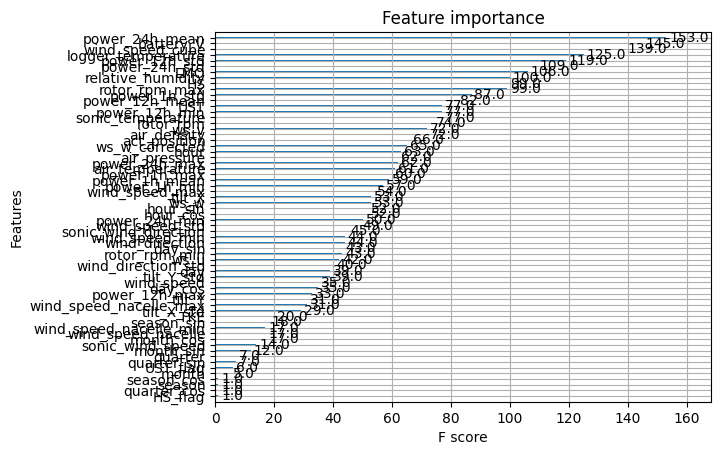

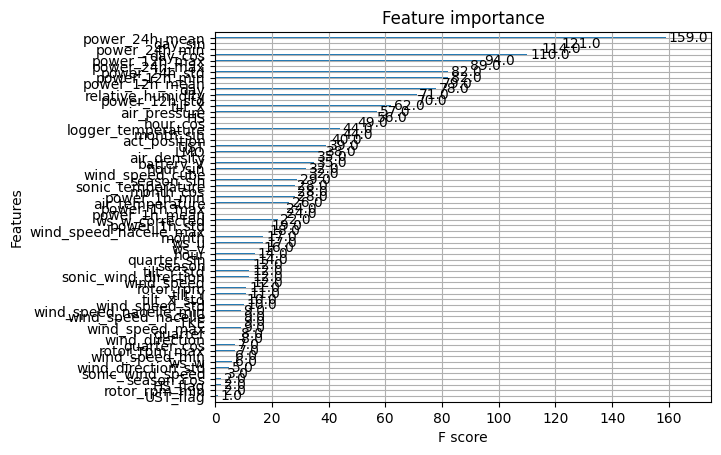

In [90]:

# Train the XGBoost model for the next hour prediction
model_next_hour = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_next_hour.fit(X_train, y_train_next_hour, eval_set=[(X_val, y_val_next_hour)], early_stopping_rounds=50, verbose=True)


xgb.plot_importance(model_next_hour)

# Make predictions for the next hour
y_pred_next_hour = model_next_hour.predict(X_test)

# Evaluate the next hour predictions
mse_next_hour = mean_squared_error(y_test_next_hour, y_pred_next_hour)
mae_next_hour = mean_absolute_error(y_test_next_hour, y_pred_next_hour)
print(f"Mean Squared Error (Next Hour): {mse_next_hour}")
print(f"Mean Absolute Error (Next Hour): {mae_next_hour}")
print(f"RMSE (Next Hour): {mse_next_hour ** 0.5}")

# Train the XGBoost model for the next day prediction
model_next_day = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_next_day.fit(X_train, y_train_next_day, eval_set=[(X_val, y_val_next_day)], early_stopping_rounds=50, verbose=True)


xgb.plot_importance(model_next_day)

# Make predictions for the next day
y_pred_next_day = model_next_day.predict(X_test)

# Evaluate the next day predictions
mse_next_day = mean_squared_error(y_test_next_day, y_pred_next_day)
mae_next_day = mean_absolute_error(y_test_next_day, y_pred_next_day)
print(f"Mean Squared Error (Next Day): {mse_next_day}")
print(f"Mean Absolute Error (Next Day): {mae_next_day}")
print(f"RMSE (Next Day): {mse_next_day ** 0.5}")

In [91]:
# get most important features
feature_importances_next = pd.DataFrame(model_next_step.feature_importances_*100, index = X_train.columns, columns=['importance_step']).sort_values('importance_step', ascending=False)
feature_importances_hour = pd.DataFrame(model_next_hour.feature_importances_*100, index = X_train.columns, columns=['importance_hour']).sort_values('importance_hour', ascending=False)
feature_importances_day = pd.DataFrame(model_next_day.feature_importances_*100, index = X_train.columns, columns=['importance_day']).sort_values('importance_day', ascending=False)

# average feature importances together for next step, next hour and next day
feature_importances = pd.concat([feature_importances_next, feature_importances_hour, feature_importances_day], axis=1)
feature_importances['average_importance'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values('average_importance', ascending=False)
feature_importances.to_csv("uebb_2_feature_importances.csv")

In [92]:
# drop features with importance less than 1%
best_features = feature_importances[feature_importances['average_importance'] > 0.01]
best_features = best_features.index.tolist()
best_features

['rotor_rpm',
 'rotor_rpm_max',
 'wind_speed_nacelle_max',
 'wind_speed',
 'sonic_wind_speed',
 'wind_speed_cube',
 'power_1h_mean',
 'season_sin',
 'quarter_cos',
 'wind_speed_max',
 'power_1h_min',
 'ws_u',
 'logger_temperature',
 'season',
 'month_sin',
 'wind_speed_nacelle',
 'hour_cos',
 'quarter_sin',
 'power_1h_max',
 'quarter',
 'hour',
 'hour_sin',
 'wind_speed_min',
 'month_cos',
 'act_position',
 'wind_direction',
 'power_24h_max',
 'month',
 'UST',
 'power_24h_min',
 'day_sin',
 'power_24h_mean',
 'HS',
 'power_12h_min',
 'power_24h_std',
 'LMO',
 'day',
 'air_temperature',
 'power_12h_mean',
 'air_density',
 'tilt_Y_std',
 'tilt_X_std',
 'power_12h_max',
 'battery_V',
 'day_cos',
 'sonic_wind_direction',
 'rotor_rpm_min',
 'tilt_X',
 'sonic_temperature',
 'power_12h_std',
 'relative_humidity',
 'air_pressure',
 'ws_w_corrected',
 'wind_direction_std',
 'ws_v',
 'power_1h_std',
 'TKE',
 'UST_flag',
 'wind_speed_nacelle_min',
 'HS_flag',
 'tilt_Y',
 'ws_w',
 'season_cos',
 '

In [99]:
# plot the highest correlated features
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,wind_speed,wind_direction,wind_speed_std,wind_direction_std,wind_speed_max,wind_speed_min,wind_speed_cube,air_temperature,relative_humidity,air_pressure,logger_temperature,battery_V,ws_u,ws_v,ws_w,sonic_temperature,sonic_wind_speed,sonic_wind_direction,tilt_X,tilt_Y,tilt_X_std,tilt_Y_std,wind_speed_nacelle,wind_speed_nacelle_max,wind_speed_nacelle_min,rotor_rpm,rotor_rpm_max,rotor_rpm_min,active_power_total,active_power_total_max,active_power_total_min,act_position,air_density,UST,UST_flag,HS,HS_flag,TKE,LMO,ws_w_corrected,season,month,hour,quarter,day,hour_sin,hour_cos,month_sin,month_cos,quarter_sin,quarter_cos,season_sin,season_cos,day_sin,day_cos,power_next_step,power_next_hour,power_next_day,power_1h_mean,power_12h_mean,power_24h_mean,power_1h_std,power_12h_std,power_24h_std,power_1h_max,power_12h_max,power_24h_max,power_1h_min,power_12h_min,power_24h_min
wind_speed,1.000000,-0.219615,0.368721,-0.569128,0.960268,0.916528,0.933521,0.018358,-0.254130,0.031236,-0.139292,-0.065887,-0.948917,-0.049244,-0.423604,-0.115247,0.988926,-0.204623,0.063729,-0.032314,0.647451,0.690487,0.903644,0.824012,0.015652,0.777151,0.708280,0.336155,0.896429,0.861608,0.865415,0.328252,0.078019,0.055377,-0.233966,0.085620,-0.323831,-0.127174,-0.127174,0.240199,0.327029,0.349027,0.109339,0.354077,0.010683,-0.187291,0.264301,-0.487650,0.333622,-0.219101,0.466841,-0.559202,-0.031595,-0.044851,-0.017548,0.891271,0.811020,0.609515,0.869801,0.596566,0.651408,0.106730,0.296490,0.467301,0.837025,0.579050,0.575284,0.869509,0.559400,0.379491
wind_direction,-0.219615,1.000000,0.392684,0.561191,-0.067332,-0.409913,-0.077135,-0.451462,0.075512,0.276448,-0.135504,-0.098209,0.242394,0.831565,0.783034,-0.463436,-0.143533,0.972623,-0.051140,-0.178031,0.151455,0.185694,-0.099480,0.050865,0.006700,-0.184225,-0.120921,-0.090047,-0.047225,-0.015077,-0.098561,0.012566,0.479818,0.605140,0.099075,0.026557,0.075775,0.590109,0.590109,0.162718,0.109624,0.007869,-0.422030,0.015962,-0.005601,0.610468,-0.021850,-0.094775,-0.215870,-0.167880,-0.149349,0.001350,-0.169778,0.008591,-0.057093,-0.053139,-0.071879,-0.010353,-0.016490,0.204520,0.040066,0.154034,0.218503,0.138083,0.015318,0.181466,0.071020,-0.048756,0.016549,-0.096125
wind_speed_std,0.368721,0.392684,1.000000,0.318333,0.597237,0.000751,0.408837,-0.229361,-0.215362,0.345309,-0.091560,0.005293,-0.344290,0.589369,0.431236,-0.394277,0.427800,0.402554,-0.055457,-0.234140,0.628420,0.727094,0.465614,0.592179,0.023308,0.319332,0.380000,0.114023,0.468681,0.532246,0.353289,0.207886,0.418206,0.716613,0.073025,0.139077,-0.001723,0.668008,0.668008,0.353390,0.297783,0.184171,-0.246385,0.189129,-0.004160,0.374008,0.052854,-0.363891,0.000026,-0.270476,0.152022,-0.307660,-0.217294,-0.029147,-0.031209,0.456887,0.387341,0.315634,0.469251,0.563673,0.439741,0.307307,0.389260,0.441912,0.503332,0.517780,0.432894,0.415650,0.338404,0.112437
wind_direction_std,-0.569128,0.561191,0.318333,1.000000,-0.381753,-0.721611,-0.404621,-0.303123,0.110423,0.198749,-0.073389,-0.036389,0.553428,0.447784,0.631830,-0.271457,-0.527030,0.533337,-0.056223,-0.108353,-0.102983,-0.071462,-0.427372,-0.231854,-0.006242,-0.448591,-0.339144,-0.213553,-0.371602,-0.306928,-0.403900,-0.097386,0.300718,0.513440,0.225637,-0.089796,0.236588,0.618087,0.618087,0.024696,-0.037173,-0.134377,-0.272849,-0.132457,-0.026259,0.434031,-0.082583,0.118870,-0.246754,-0.017381,-0.250296,0.203971,-0.110199,0.046257,-0.011263,-0.374511,-0.332712,-0.231324,-0.339483,-0.061571,-0.190252,0.128572,0.052900,-0.064184,-0.291494,-0.079195,-0.149166,-0.374282,-0.202528,-0.208897
wind_speed_max,0.960268,-0.067332,0.597237,-0.381753,1.000000,0.789435,0.916777,-0.063031,-0.283003,0.129849,-0.156500,-0.062878,-0.907849,0.129835,-0.237331,-0.225332,0.967753,-0.052183,0.040105,-0.103743,0.729502,0.796537,0.907802,0.882944,0.019833,0.756250,0.719566,0.319311,0.901056,0.893359,0.841972,0.346640,0.199735,0.270348,-0.175415,0.102470,-0.275733,0.097549,0.097549,0.305647,0.370027,0.355841,0.024090,0.360977,0.0

<Axes: >

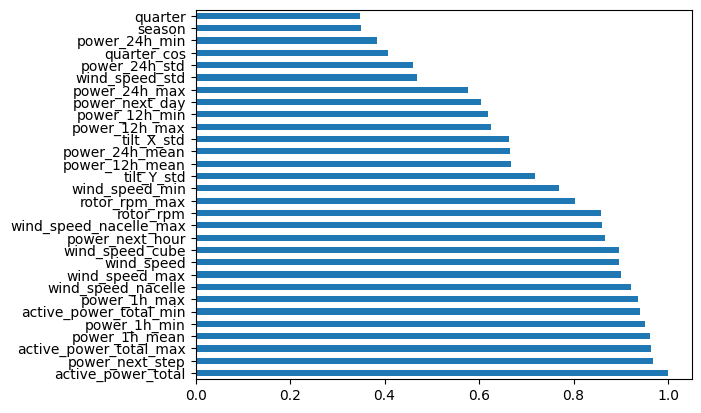

In [100]:
# plot the highest correlated features for column 'power_(kw)'
corr[target_variable].sort_values(ascending=False).head(30).plot(kind='barh')

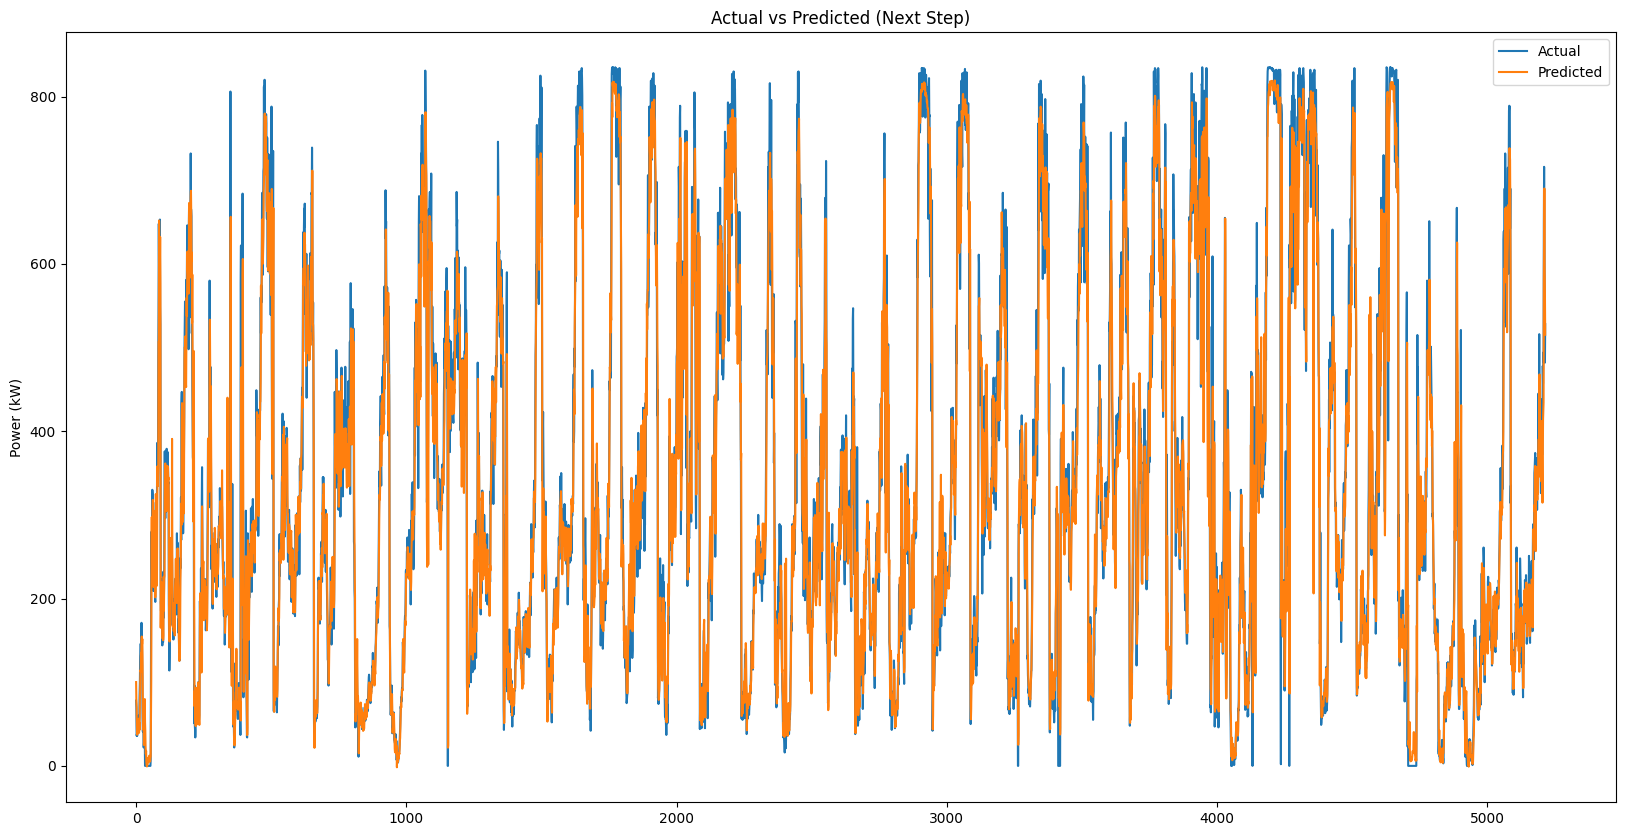

In [101]:
# Plot the actual and predicted values for the next step
plt.figure(figsize=(20, 10))
plt.plot(y_test_next_step.values, label='Actual')
plt.plot(y_pred_next_step, label='Predicted')
plt.title('Actual vs Predicted (Next Step)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

In [102]:
# get the feature importance scores with feature names
feature_importances = pd.DataFrame(model_next_step.feature_importances_,
                                      index=X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
feature_importances.sort_values(by='importance', ascending=False).to_dict()['importance']


{'rotor_rpm': 0.6631166338920593,
 'rotor_rpm_max': 0.12901191413402557,
 'sonic_wind_speed': 0.10301002115011215,
 'wind_speed_max': 0.01982322707772255,
 'wind_speed_nacelle': 0.011078986339271069,
 'ws_u': 0.004535789135843515,
 'wind_speed_min': 0.0036775339394807816,
 'wind_speed_cube': 0.003444485366344452,
 'tilt_X_std': 0.0033865522127598524,
 'wind_direction_std': 0.0029344672802835703,
 'power_1h_min': 0.0025507700629532337,
 'power_1h_max': 0.00209143478423357,
 'tilt_Y_std': 0.0020003076642751694,
 'power_1h_mean': 0.0018743780674412847,
 'hour': 0.0016881300834938884,
 'rotor_rpm_min': 0.0016239009564742446,
 'logger_temperature': 0.0014954765792936087,
 'wind_speed_nacelle_max': 0.0014717342564836144,
 'hour_cos': 0.0014445794513449073,
 'wind_direction': 0.0014253371628001332,
 'wind_speed_nacelle_min': 0.001417617779225111,
 'wind_speed_std': 0.0013899315381422639,
 'HS': 0.001359203946776688,
 'air_temperature': 0.001328465179540217,
 'UST': 0.0012870184145867825,
 'ac

In [103]:
model_next_step.feature_importances_

array([3.4444854e-03, 9.7686332e-04, 5.6390790e-04, 1.0257908e-03,
       1.1038349e-03, 7.3348265e-04, 1.8743781e-03, 2.5507701e-03,
       1.2901191e-01, 1.3899315e-03, 1.3284652e-03, 1.6239010e-03,
       1.1098253e-03, 8.5270545e-04, 1.9823227e-02, 1.0158343e-03,
       6.7164126e-04, 9.1842946e-04, 1.4445795e-03, 6.6957506e-04,
       8.2566182e-04, 8.0103695e-04, 1.0516975e-03, 9.1646437e-04,
       1.1853857e-03, 7.2296325e-04, 4.5357891e-03, 1.4253372e-03,
       5.9636362e-04, 9.4463490e-04, 5.9322378e-04, 1.0653834e-03,
       7.6695438e-04, 6.9169974e-04, 1.6881301e-03, 8.5525401e-04,
       0.0000000e+00, 8.9426298e-04, 2.0003077e-03, 1.0171406e-03,
       9.8285975e-04, 3.3865522e-03, 2.9344673e-03, 3.6775339e-03,
       1.0430715e-03, 1.4717343e-03, 1.1078986e-02, 7.3788175e-04,
       1.4176178e-03, 1.2870184e-03, 7.1646454e-04, 8.7467209e-04,
       5.2215811e-04, 2.0914348e-03, 4.6280617e-04, 9.5527899e-04,
       1.0301002e-01, 7.4343500e-04, 8.0482423e-04, 5.3736806e